In [1]:
import typing as tp
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration

plt.gray()

<Figure size 640x480 with 0 Axes>

PSFs from widely used benchmark [Levin at el](https://dspace.mit.edu/bitstream/handle/1721.1/59815/Levin-2009-Understanding%20and%20evaluating%20blind%20deconvolution%20algorithms.pdf?sequence=1&isAllowed=y)

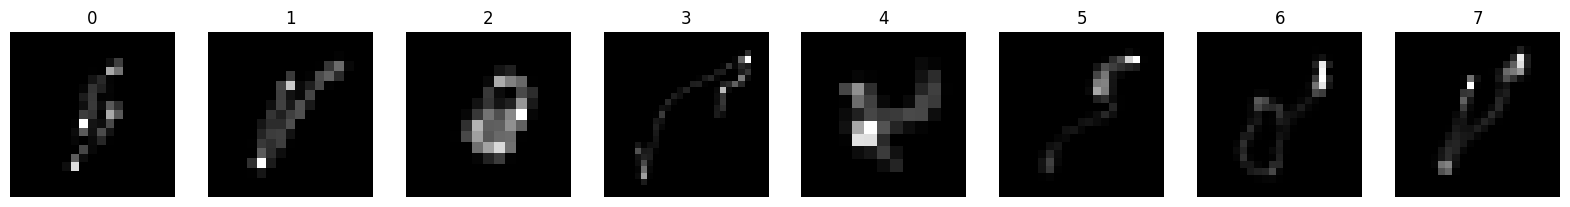

In [2]:
files = sorted(list(Path('/home/chaganovaob/edu/neural-deconvolution/datasets/levin/Levin09blurdata/').rglob('*.mat')))
psfs = []
ys = []

fig, axs = plt.subplots(1, 8, figsize=(20,10))
for i in range(8):
    img = scipy.io.loadmat(files[i])
    x = img['x']
    y = img['y']
    psf = img['f']
    ys.append(y)
    psfs.append(psf)
    axs[i].imshow(psf)
    axs[i].axis('off')
    axs[i].set_title(i)


Two similar PSFs

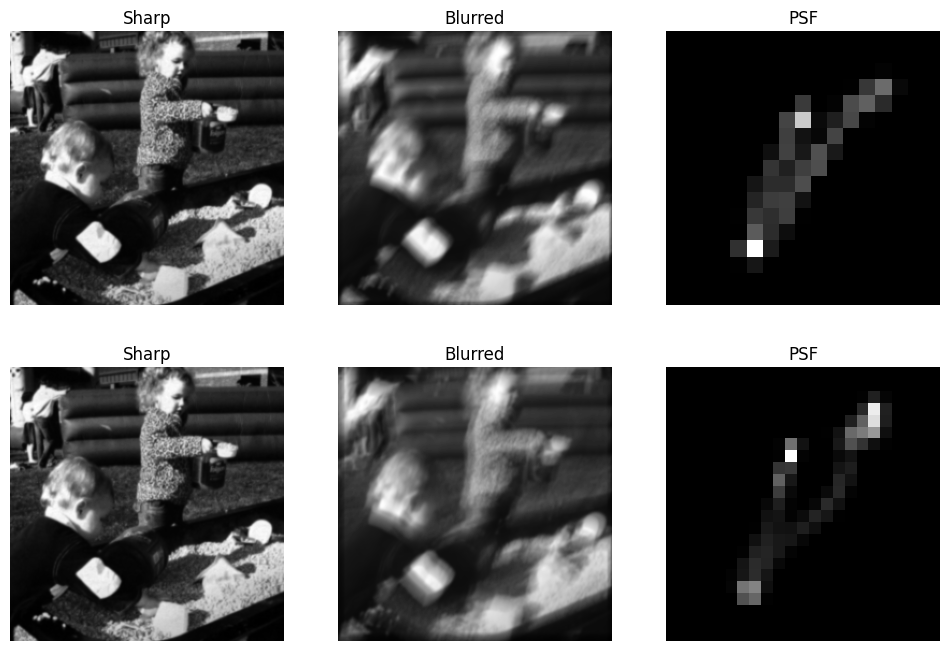

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

psf_1 = psfs[1]
blurred_1 = conv2(x, psf_1, 'same')
axs[0, 0].imshow(x)
axs[0, 0].axis('off')
axs[0, 0].set_title('Sharp')
axs[0, 1].imshow(blurred_1)
axs[0, 1].axis('off')
axs[0, 1].set_title('Blurred')
axs[0, 2].imshow(psf_1)
axs[0, 2].axis('off')
axs[0, 2].set_title('PSF')


psf_7 = psfs[7]
blurred_7 = conv2(x, psf_7, 'same')
axs[1, 0].imshow(x)
axs[1, 0].axis('off')
axs[1, 0].set_title('Sharp')
axs[1, 1].imshow(blurred_7)
axs[1, 1].axis('off')
axs[1, 1].set_title('Blurred')
axs[1, 2].imshow(psf_7)
axs[1, 2].axis('off')
axs[1, 2].set_title('PSF')

plt.show()

# 1 Classical algorithmns

In [4]:
def deblur_and_show(
    sharp_image: np.array,
    blurred_image: np.array,
    psf_correct: np.array,
    psf_incorrect: np.array,
    algorithm: tp.Callable,
    **algo_params,
):
    """Show deblurred image with correct and incorrect PSF."""
    restored_correct = algorithm(
        image=blurred_image,
        psf=psf_correct,
        **algo_params,
    )

    restored_incorrect = algorithm(
        image=blurred_image,
        psf=psf_incorrect,
        **algo_params,
    )

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
    [axi.set_axis_off() for axi in ax.ravel()]

    ax[0,0].imshow(blurred_image)
    ax[0,0].set_title('Blurred')

    ax[0,1].imshow(sharp_image)
    ax[0,1].set_title('Sharp')

    ax[0,2].imshow(restored_correct, vmin=restored_correct.min(), vmax=restored_correct.max())
    ax[0,2].set_title('Deconvolved with correct PSF')

    ax[0,3].imshow(psf_correct)
    ax[0,3].set_title('Correct PSF')

    ax[1,0].imshow(blurred_image)
    ax[1,0].set_title('Blurred')

    ax[1,1].imshow(sharp_image)
    ax[1,1].set_title('Sharp')

    ax[1,2].imshow(restored_incorrect, vmin=restored_incorrect.min(), vmax=restored_incorrect.max())
    ax[1,2].set_title('Deconvolved with incorrect PSF')

    ax[1,3].imshow(psf_incorrect)
    ax[1,3].set_title('Incorrect PSF')


## 1.1 Lucy-Richardson

### 1.1.1 Gaussian kernel

In [5]:
def gkern(sigma: float):
    """Creates gaussian kernel with sigma of `sigma`"""
    size = int(3 * sigma)
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

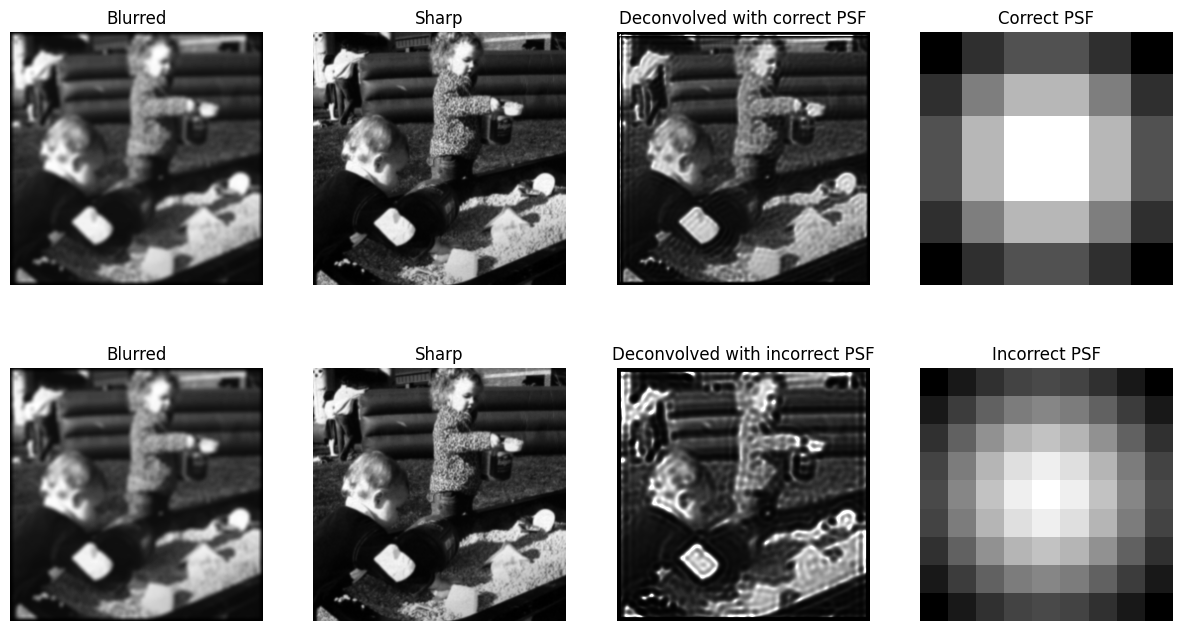

In [7]:
psf_gaussian_small = gkern(sigma=2)
psf_gaussian_big = gkern(sigma=3)

blurred_gaussian_small = conv2(x, psf_gaussian_small)
blurred_gaussian_big = conv2(x, psf_gaussian_big)

deblur_and_show(
    sharp_image=x,
    blurred_image=blurred_gaussian_small,
    psf_correct=psf_gaussian_small,
    psf_incorrect=psf_gaussian_big,
    num_iter=40,
    algorithm=restoration.richardson_lucy,
)

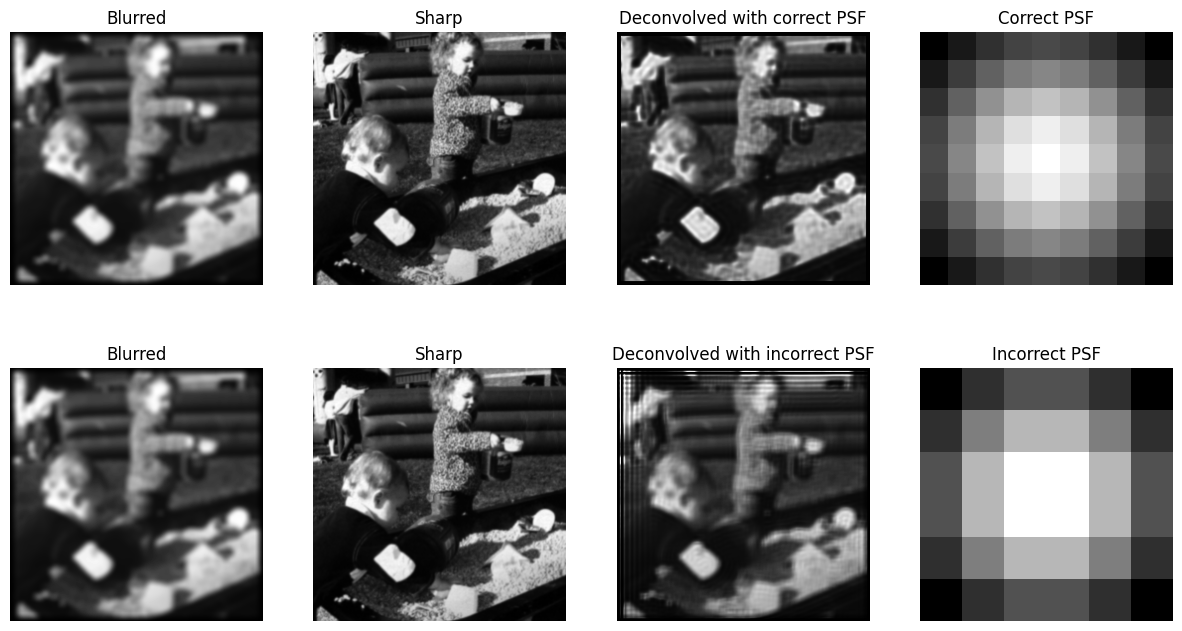

In [10]:
deblur_and_show(
    sharp_image=x,
    blurred_image=blurred_gaussian_big,
    psf_correct=psf_gaussian_big,
    psf_incorrect=psf_gaussian_small,
    num_iter=120,
    algorithm=restoration.richardson_lucy,
)

### 1.1.2 Motion blur kernel

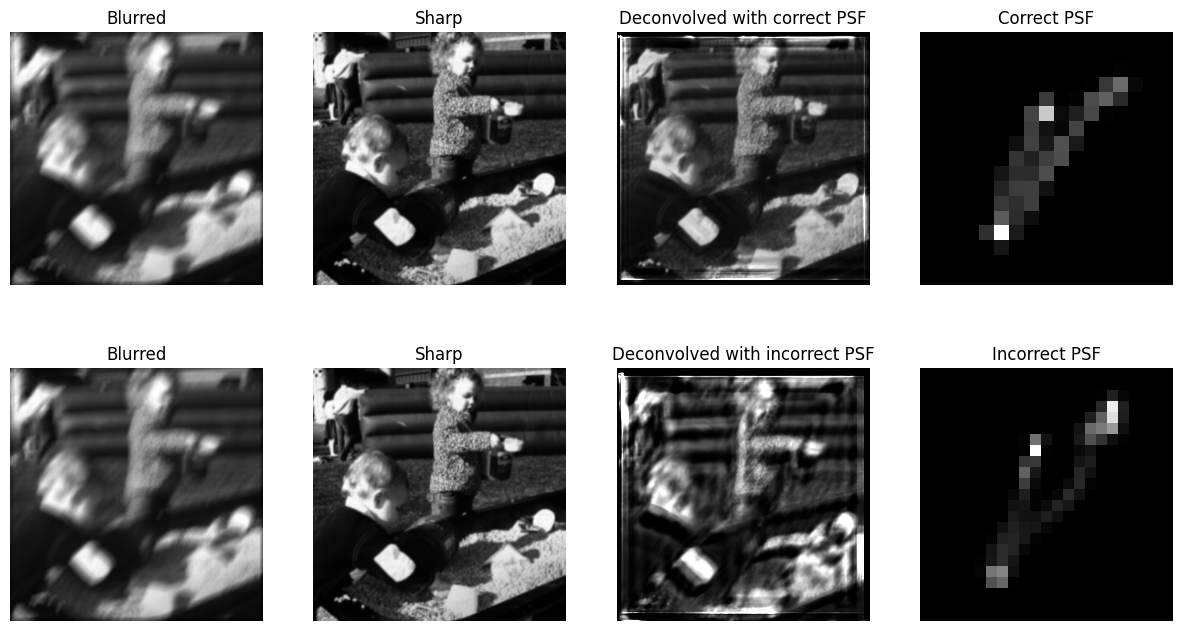

In [11]:
deblur_and_show(
    sharp_image=x,
    blurred_image=blurred_1,
    psf_correct=psf_1,
    psf_incorrect=psf_7,
    num_iter=40,
    algorithm=restoration.richardson_lucy,
)

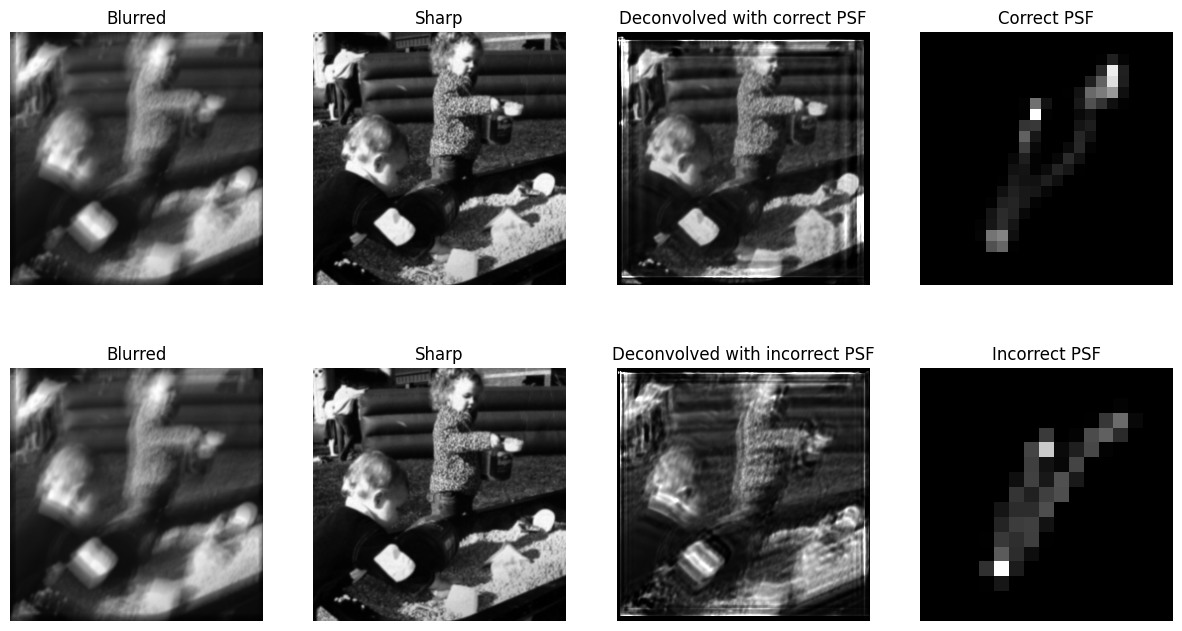

In [12]:
deblur_and_show(
    sharp_image=x,
    blurred_image=blurred_7,
    psf_correct=psf_7,
    psf_incorrect=psf_1,
    num_iter=40,
    algorithm=restoration.richardson_lucy,
)

## 1.2 Wiener

### 1.2.1 Gaussian kernel

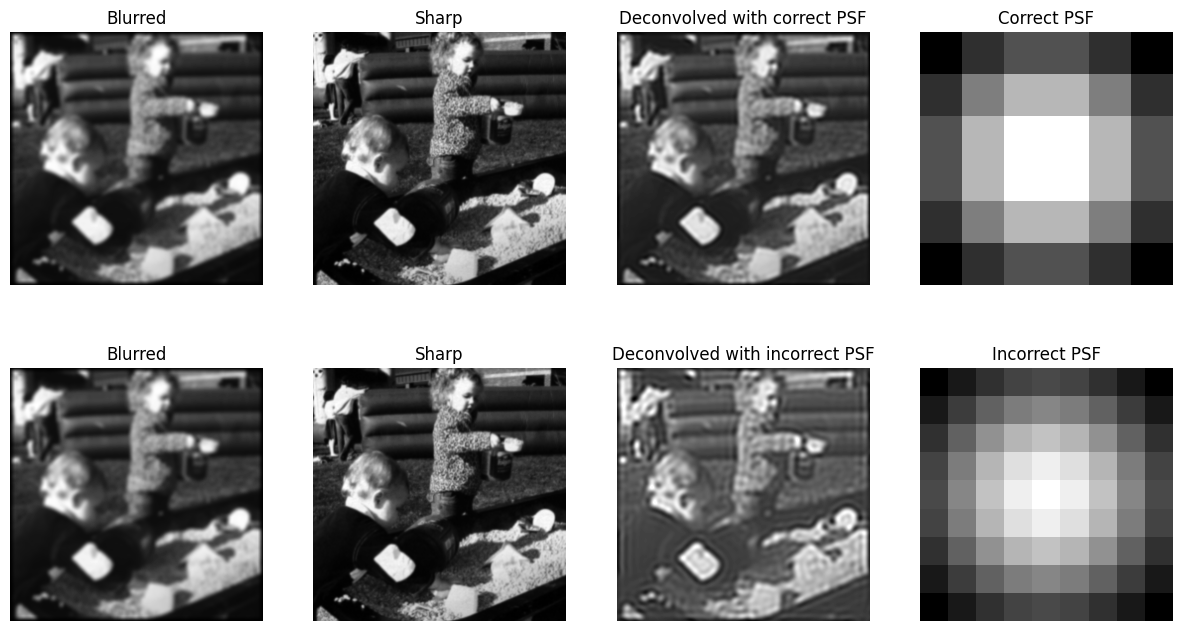

In [18]:
deblur_and_show(
    sharp_image=x,
    blurred_image=blurred_gaussian_small,
    psf_correct=psf_gaussian_small,
    psf_incorrect=psf_gaussian_big,
    algorithm=restoration.wiener,
    balance=0.1,
)

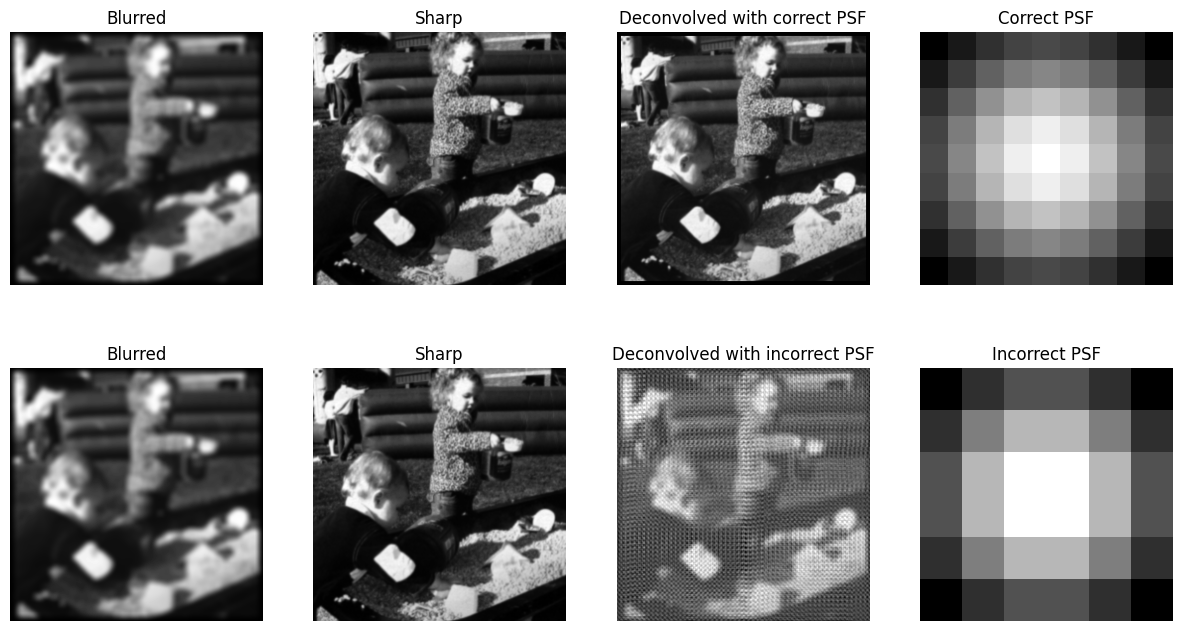

In [16]:
deblur_and_show(
    sharp_image=x,
    blurred_image=blurred_gaussian_big,
    psf_correct=psf_gaussian_big,
    psf_incorrect=psf_gaussian_small,
    algorithm=restoration.wiener,
    balance=0,
)

### 1.2.2 Motion blur kernel

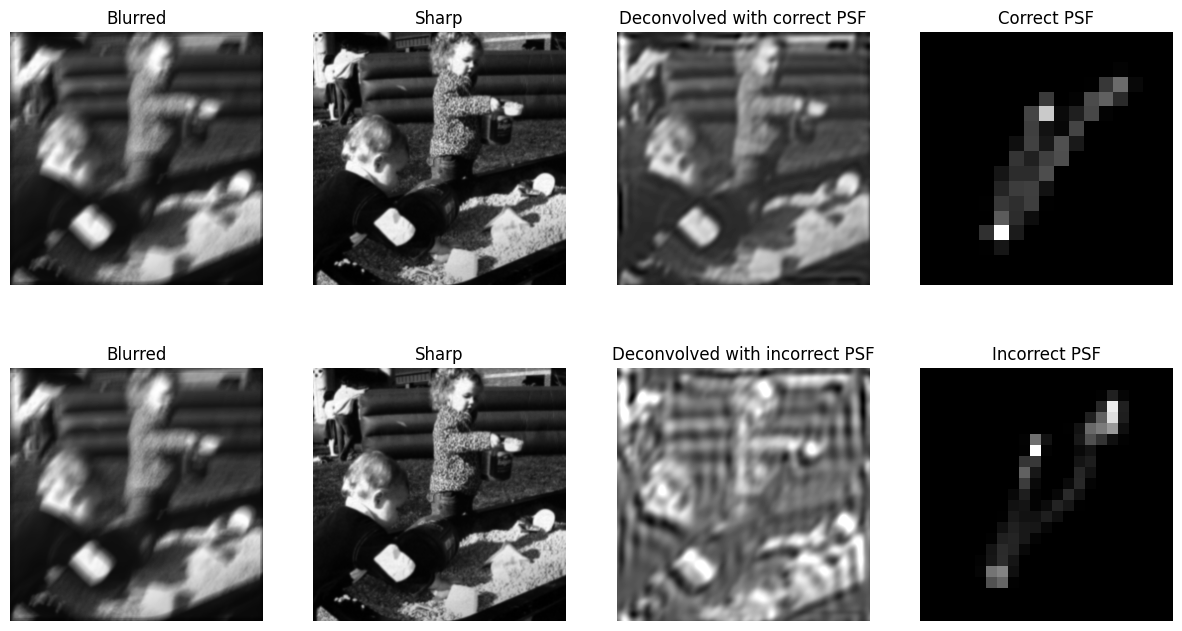

In [20]:
deblur_and_show(
    sharp_image=x,
    blurred_image=blurred_1,
    psf_correct=psf_1,
    psf_incorrect=psf_7,
    algorithm=restoration.wiener,
    balance=0.5,
)

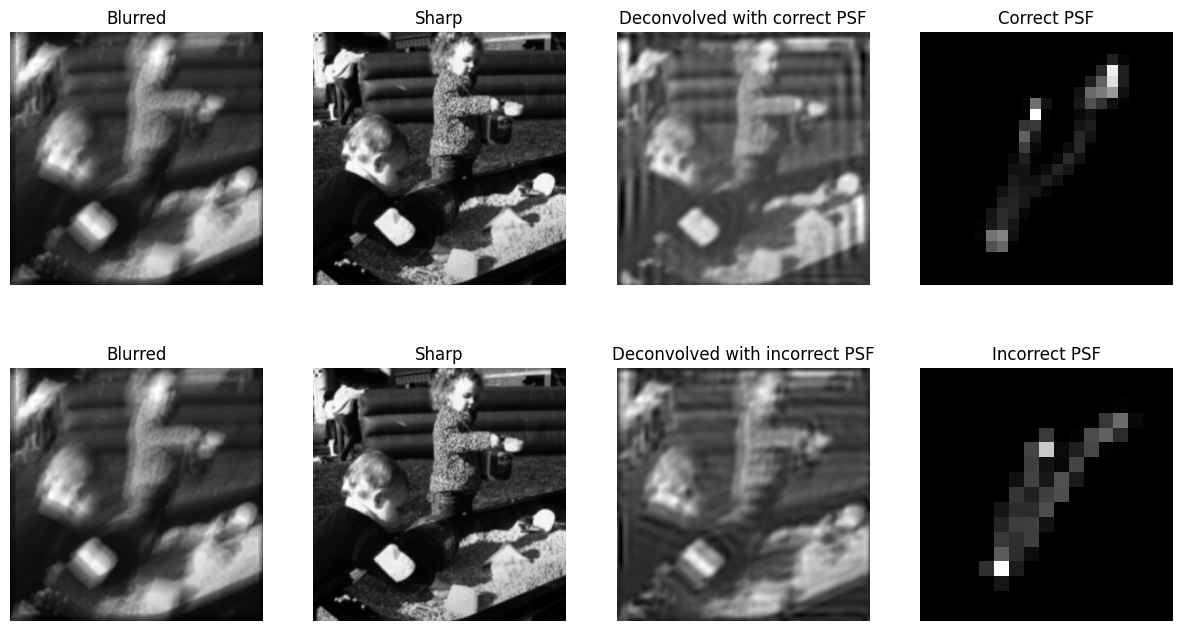

In [21]:
deblur_and_show(
    sharp_image=x,
    blurred_image=blurred_7,
    psf_correct=psf_7,
    psf_incorrect=psf_1,
    algorithm=restoration.wiener,
    balance=0.5,
)

# 2 Neural models

## RGDN

In [22]:
import sys
sys.path.append('/home/chaganovaob/edu/neural-deconvolution/')

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize

from src.deconv.neural.rgdn.model import OptimizerRGDN
from src.data.blurry_image_dataset import BlurryImageDatasetOnTheFly, get_data

plt.gray()

<Figure size 640x480 with 0 Axes>

In [23]:
def load_trained_model(model: nn.Module, ckpt_path: str) -> nn.Module:  
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

In [24]:
def torch_conv(x: torch.tensor, psf: torch.tensor) -> torch.tensor:
    y = torch.nn.functional.conv2d(x, psf)
    nl = np.random.uniform(0.003, 0.015)
    y = y + nl * torch.randn_like(y)
    y = torch.clamp(y * 255.0, 0, 255)
    y = y.type(torch.ByteTensor)
    return y.float() / 255.0

In [25]:
def deblur_and_show_nn(
    sharp_image: torch.tensor,
    blurred_image: torch.tensor,
    psf_correct: torch.tensor,
    psf_mirrored: torch.tensor,
    model: torch.nn.Module,
):
    """Show deblurred image with correct and incorrect PSF."""
    restored_correct = model(blurred_image, psf_correct, psf_mirrored)[-1].detach()

    restored_incorrect = model(blurred_image, psf_mirrored, psf_correct)[-1].detach()


    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
    [axi.set_axis_off() for axi in ax.ravel()]

    ax[0,0].imshow(blurred_image.squeeze(0).squeeze(0))
    ax[0,0].set_title('Blurred with correct PSF')

    ax[0,1].imshow(sharp_image.squeeze(0).squeeze(0))
    ax[0,1].set_title('Sharp')

    ax[0,2].imshow(restored_correct.squeeze(0).squeeze(0), vmin=restored_correct.min(), vmax=restored_correct.max())
    ax[0,2].set_title('Deconvolved with correct PSF')

    ax[0,3].imshow(psf_correct.squeeze(0).squeeze(0))
    ax[0,3].set_title('Correct PSF')

    ax[1,0].imshow(blurred_image.squeeze(0).squeeze(0))
    ax[1,0].set_title('Blurred with correct PSF')

    ax[1,1].imshow(sharp_image.squeeze(0).squeeze(0))
    ax[1,1].set_title('Sharp')

    ax[1,2].imshow(restored_incorrect.squeeze(0).squeeze(0), vmin=restored_incorrect.min(), vmax=restored_incorrect.max())
    ax[1,2].set_title('Deconvolved with incorrect PSF')

    ax[1,3].imshow(psf_mirrored.squeeze(0).squeeze(0))
    ax[1,3].set_title('Incorrect (mirrored) PSF')

In [26]:
rgdn = OptimizerRGDN(num_steps=10, is_rgb=False).cpu()
rgdn = load_trained_model(rgdn, ckpt_path='/home/chaganovaob/edu/neural-deconvolution/models/RGDN-GRAY-60')

In [27]:
_, valid_files, _ = get_data('/home/chaganovaob/edu/neural-deconvolution/datasets/Linnaeus 5 256X256', is_silent=False)
valid_dataset = BlurryImageDatasetOnTheFly(file_name_list=valid_files, is_rgb=False)
val_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

y, x_gt, k, kt = next(iter(val_loader))

Files are loaded.
Train size:  6000 	 Valid size:  1000 	 Test size:  1000


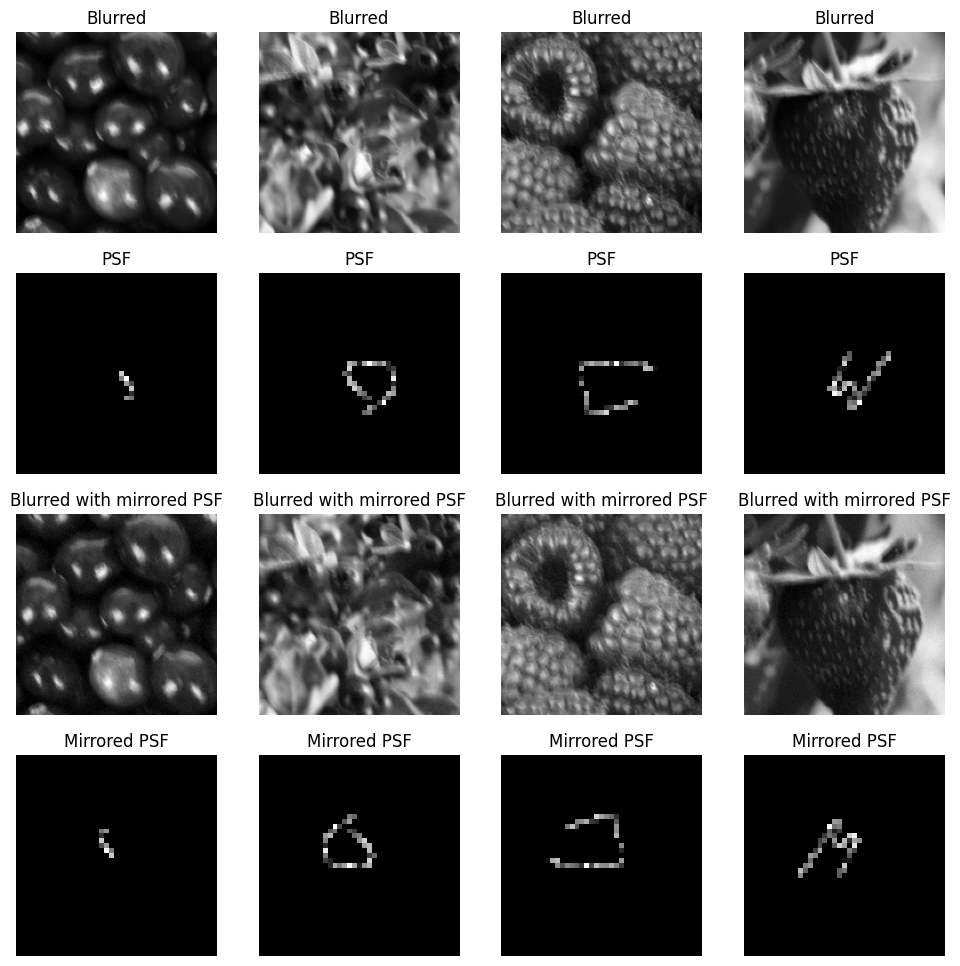

In [30]:
y, x_gt, k, kt = next(iter(val_loader))

y_blurred = torch_conv(x_gt, k)
y_blurred_t = torch_conv(x_gt, kt)

fig, axs = plt.subplots(4, len(k), figsize=(12, 12))

for i in range(len(k)):
    axs[0, i].imshow(y_blurred[i][0])
    axs[0, i].axis('off')
    axs[0, i].set_title('Blurred')

    axs[1, i].imshow(k[i][0])
    axs[1, i].axis('off')
    axs[1, i].set_title('PSF')

    axs[2, i].imshow(y_blurred_t[i][0])
    axs[2, i].axis('off')
    axs[2, i].set_title('Blurred with mirrored PSF')

    axs[3, i].imshow(kt[i][0])
    axs[3, i].axis('off')
    axs[3, i].set_title('Mirrored PSF')

### Vizualization

As incorrect PSF mirrored PSF are used here.

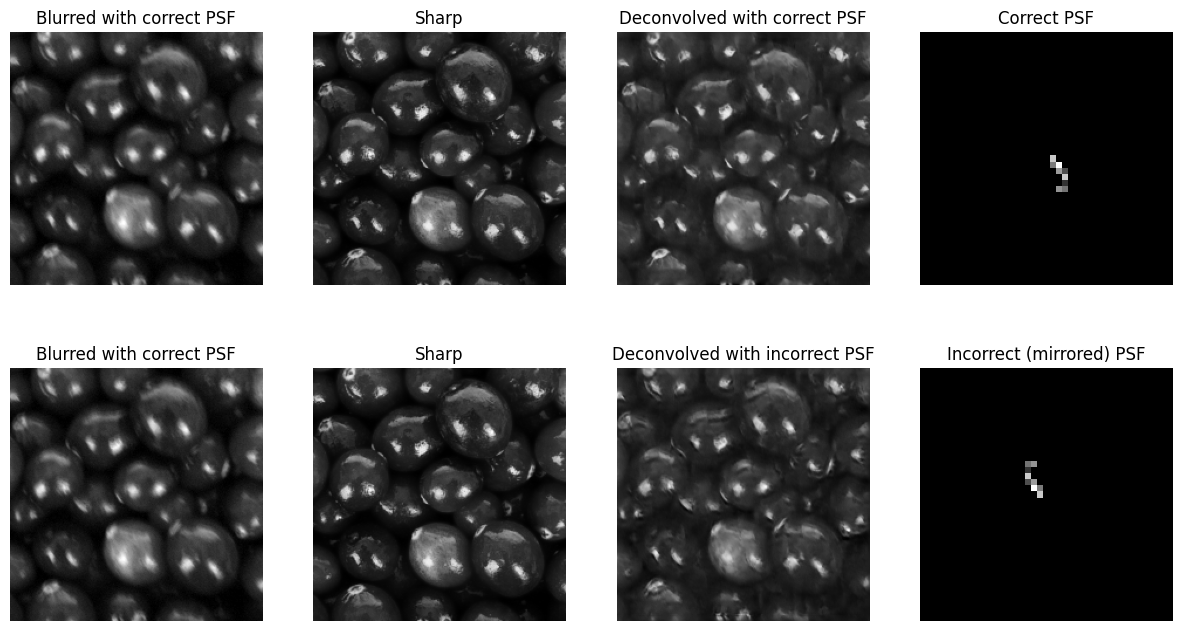

In [31]:
ind = 0
deblur_and_show_nn(
    sharp_image=x_gt[ind].unsqueeze(0),
    blurred_image=y[ind].unsqueeze(0),
    psf_correct=k[ind].unsqueeze(0),
    psf_mirrored=kt[ind].unsqueeze(0),
    model=rgdn,
)

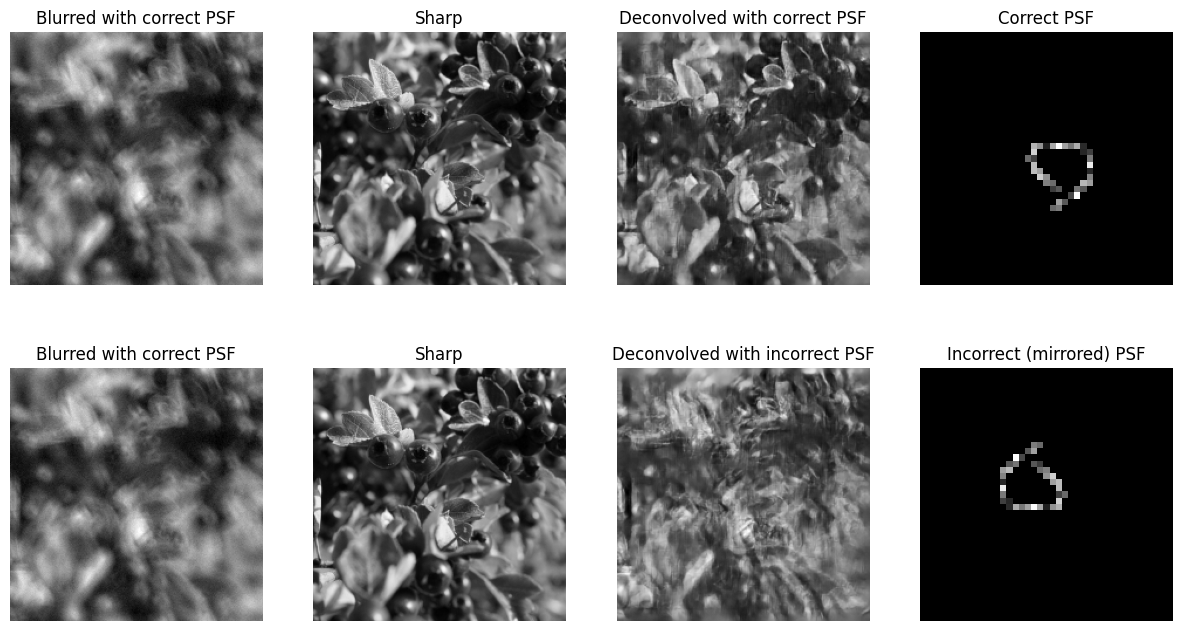

In [32]:
ind = 1
deblur_and_show_nn(
    sharp_image=x_gt[ind].unsqueeze(0),
    blurred_image=y[ind].unsqueeze(0),
    psf_correct=k[ind].unsqueeze(0),
    psf_mirrored=kt[ind].unsqueeze(0),
    model=rgdn,
)

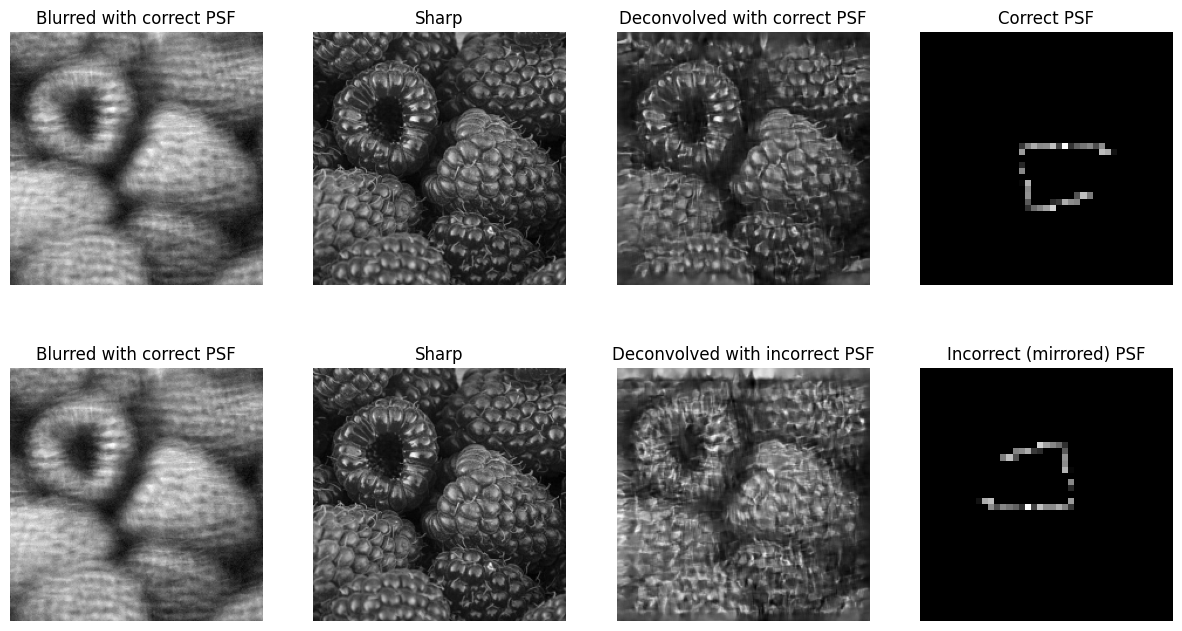

In [33]:
ind = 2
deblur_and_show_nn(
    sharp_image=x_gt[ind].unsqueeze(0),
    blurred_image=y[ind].unsqueeze(0),
    psf_correct=k[ind].unsqueeze(0),
    psf_mirrored=kt[ind].unsqueeze(0),
    model=rgdn,
)

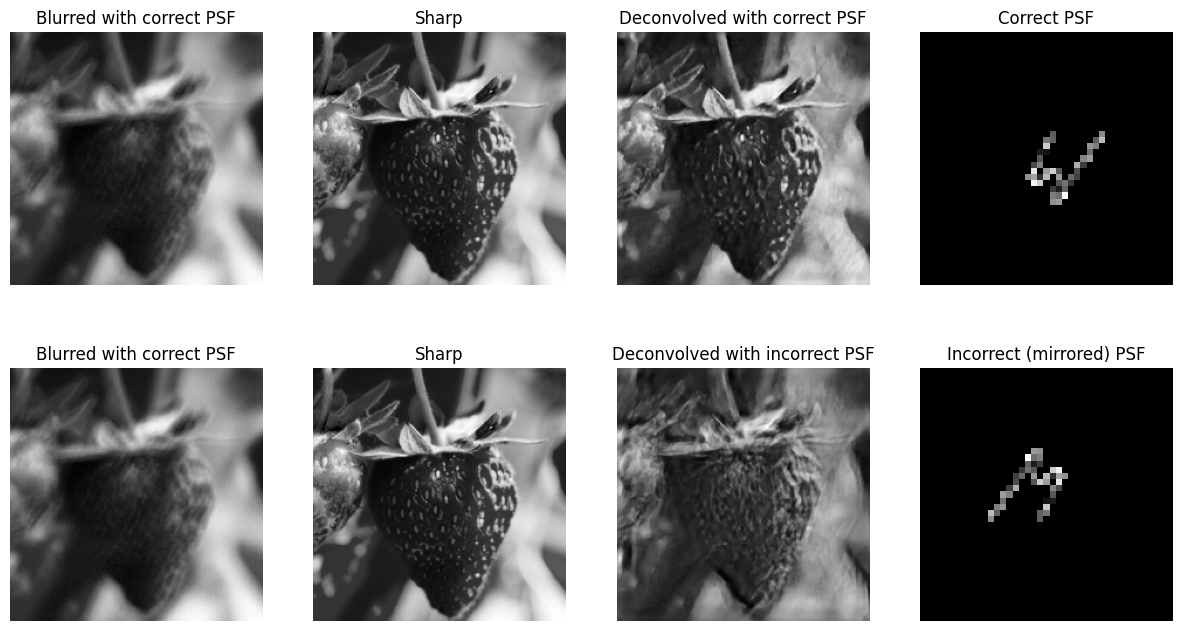

In [34]:
ind = 3
deblur_and_show_nn(
    sharp_image=x_gt[ind].unsqueeze(0),
    blurred_image=y[ind].unsqueeze(0),
    psf_correct=k[ind].unsqueeze(0),
    psf_mirrored=kt[ind].unsqueeze(0),
    model=rgdn,
)